In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from keras.models import Sequential
from keras.models import Model
from keras.layers import Concatenate,Input, Dense, Flatten, Reshape, MaxPooling2D, Conv2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dense, Dropout, BatchNormalization, LeakyReLU
from keras.optimizers import SGD
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, explained_variance_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle 
from keras.preprocessing import image as kimage
import skimage.io as io
import random
import sys
import pickle as pkl
from imblearn.keras import BalancedBatchGenerator
from keras.utils import np_utils
from sklearn.metrics import classification_report
import cv2
import keras

In [0]:
keras.__version__

'2.2.5'

In [0]:
X_train = np.load("/content/drive/My Drive/Dataset/Train_segnali/train_speriamo_bene_completo_X.npy")
y_train = np.load("/content/drive/My Drive/Dataset/Train_segnali/train_speriamo_bene_completo_Y.npy")
X_test = np.load("/content/drive/My Drive/Dataset/Test_segnali/X_test_speriamo_bene.npy")
y_test = np.load("/content/drive/My Drive/Dataset/Test_segnali/y_test_speriamo_bene.npy")

In [0]:
np.bincount(y_train.astype(np.int64))

array([132349,  78418])

In [0]:
def balanced_flow_from_directory(flow_from_directory):
    for immagini, classi in flow_from_directory:
         yield custom_balance(immagini, classi)
            
def custom_balance(immagini, classi):
    rus = RandomUnderSampler()
    X_resampled, y_resampled = rus.fit_sample(immagini.reshape(immagini.shape[0], immagini.shape[1]*immagini.shape[2]*immagini.shape[3]), classi)     
    X_resampled = X_resampled.reshape(X_resampled.shape[0], immagini.shape[1], immagini.shape[2], immagini.shape[3])
    X_resampled, y_resampled = shuffle(X_resampled, y_resampled)
    #y_resampled = y_resampled.reshape(y_resampled.shape[0], 1, 1, 1) #da mettere se uso model_conv()
    y_resampled = np_utils.to_categorical(y_resampled, 2) #da mettere se uso model_flat()
    return(X_resampled, y_resampled)

In [0]:
from keras.preprocessing import image as kimage
from keras.preprocessing import image as kimage
from keras.applications.resnet import  ResNet50
from keras.applications import resnet
from keras.applications import resnet_v2
model = ResNet50(input_shape = (40, 40, 3),
                 include_top=False)
train_img_pro = kimage.ImageDataGenerator(preprocessing_function=resnet.preprocess_input)
#test_img_pro = kimage.ImageDataGenerator(preprocessing_function=resnet.preprocess_input

In [0]:
#X_train = preprocess_input(X_train.astype(np.float64))
#X_test = preprocess_input(X_test.astype(np.float64))

In [0]:
#train_processing_flow = .ImageDataGenerator() DA METTERE NEL PROGETTO FOGLIE MALATE!!
#train_processing_flow = kimage.ImageDataGenerator()
train_generator_flow = train_img_pro.flow((X_train, y_train), 
                    batch_size=200,
                    shuffle=True #riordino i dati in maniera casuale
                    )      
train_generator_bal = balanced_flow_from_directory(train_generator_flow)

In [0]:
base_net = ResNet50(input_shape=(40,40,3),
                         include_top=False, #ignorare l'ultimo fully connected
                         weights='imagenet', #pesi ottimizzati su imagenet
                         pooling='avg')


In [0]:
for layer in base_net.layers:
  layer.trainable = False #Blocchiamo tutti i livelli della rete e non alleniamoli

In [0]:
base_net.summary()

In [0]:
#Attacchiamo i full dense che servono a noi per il nostro problema
from keras.models import Model
from keras.layers import Dense
import keras
from keras.regularizers import l1_l2
#base_net = Model(base_net.input, base_net.layers[-1].output)
x = base_net.output
x = Dense(512, activation = "relu", kernel_regularizer=l1_l2(l1=0.01))(x)
#x = Dense(512, activation = "relu")(x)
x = Dense(264, activation = "relu")(x)
x = Dropout(0.6)(x)
pred = Dense(2, activation = "softmax")(x)
net = Model(inputs=base_net.input, outputs = pred)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.summary()

In [0]:
import keras as ks
opt = ks.optimizers.Nadam(lr=0.1, beta_1=0.9, beta_2=0.99)
opt2 = SGD(lr=0.1, momentum=0.9, nesterov=True, decay=0.001) # lr = 0.01, decay=0.0001
opt3 = ks.optimizers.RMSprop(lr=0.001, rho=0.9)
opt4 = ks.optimizers.Adagrad(lr=0.01)
opt5 = ks.optimizers.Adadelta(lr= 1.0, rho=0.95)
opt6 = ks.optimizers.Adam(lr=0.001, beta_1=0.6, beta_2=0.999, amsgrad=False)
opt7 = ks.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999)

In [0]:
net.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt2, metrics = ['accuracy'])

In [0]:
from keras.callbacks import History
import warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
history = History()
net.fit_generator(train_generator_bal, epochs = 40, callbacks=[history], steps_per_epoch= 200)

In [0]:
# test_generator_flow = test_img_pro.flow((X_test, y_test), 
#                     batch_size=200,
#                     shuffle=True #riordino i dati in maniera casuale,
#                     )      
# test_generator_flow = balanced_flow_from_directory(test_generator_flow)

In [0]:
prova = resnet.preprocess_input(X_train)

In [0]:
net.evaluate(X_train,np_utils.to_categorical(y_train))

210767/210767 [==============================] - 92s 437us/step


[5.305714778491514, 0.42020809709299844]

In [0]:
X_test = resnet.preprocess_input(X_test)

In [0]:
prediction_test = net.predict(prova)

In [0]:
prediction_test.shape
np_utils.to_categorical(y_test).argmax(axis = -1)

array([0, 0, 0, ..., 1, 1, 1])

In [0]:
print(net.evaluate(X_test, np_utils.to_categorical(y_test)))

32792/32792 [==============================] - 19s 575us/step
[4.169478711863208, 0.7604903635032935]


In [0]:
base_net.summary()

# Crop dei layers 

In [0]:
#X_train = resnet.preprocess_input(X_train)
#X_test = resnet.preprocess_input(X_test)

In [0]:
base_net = Model(base_net.input, base_net.layers[-9].output)
#base_net2.summary()

In [0]:
#base_net = Model(base_net.input, base_net.layers[-9].output)
x = base_net.output
x = Flatten()(x)
x = Dense(512, activation = "relu")(x)#, kernel_regularizer=l1_l2(l1=0.01)
#x = Dense(512, activation = "relu")(x)
#x = Dense(264, activation = "relu")(x)
x = Dropout(0.6)(x)
pred = Dense(2, activation = "softmax")(x)
net = Model(inputs=base_net.input, outputs = pred)

In [0]:
opt = ks.optimizers.Nadam(lr=0.1, beta_1=0.9, beta_2=0.99)
opt2 = SGD(lr=0.01, momentum=0.9, nesterov=True, decay=0.001) # lr = 0.01, decay=0.0001
opt3 = ks.optimizers.RMSprop(lr=0.001, rho=0.9)
opt4 = ks.optimizers.Adagrad(lr=0.01)
opt5 = ks.optimizers.Adadelta(lr= 1.0, rho=0.95)
opt6 = ks.optimizers.Adam(lr=0.001, beta_1=0.6, beta_2=0.999, amsgrad=False)
opt7 = ks.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999)

In [0]:
net.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt2, metrics = ['accuracy'])

In [0]:
from keras.callbacks import History
import warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
history = History()
net.fit_generator(train_generator_bal, epochs = 50, callbacks=[history], steps_per_epoch= 200)

In [0]:
X_test = resnet.preprocess_input(X_test)
prova = resnet.preprocess_input(X_train)

In [0]:
prediction_test = net.predict(X_test)

In [0]:
import os
import skimage.io as io
from PIL import Image
X = []
Y = []
conteggio = []
i = 0 
path = r"/content/drive/My Drive/Dataset/dataset_classificazione_multiclasse_creato_da_noi/"
Class=os.listdir(path)
for a in Class:
    new_path = path+a
    class_2 = os.listdir(new_path)
    for j in class_2: 
        image = io.imread(path+a+"/"+j)
        imResize = cv2.resize(image,(40,40))
        #image_from_array = Image.fromarray(image, 'RGB')
        X.append(np.asarray(imResize))
        Y.append(1)
      #train = np.concatenate([train,np.expand_dims(np.asarray(image), axis = 0)], axis = 0)
      #train_labels = np.concatenate([train_labels,np.array([a])], axis = 0)

In [0]:
X_inference = resnet.preprocess_input(np.array(X))
y_inference = np_utils.to_categorical(Y)

In [0]:
#net.save_weights("/content/drive/My Drive/Pesi_modelli/pesi_si_no.hdf5")

In [0]:
#net.save("/content/drive/My Drive/Pesi_modelli/modello_si_no.h5")

In [0]:
print(net.evaluate(X_inference, y_inference))

155/155 [==============================] - 0s 306us/step
[0.0007710352299674865, 1.0]


predizione 1


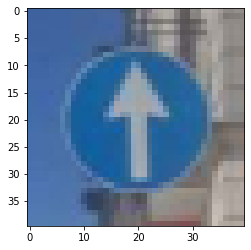

predizione 1


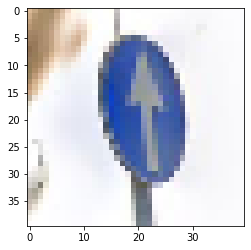

predizione 1


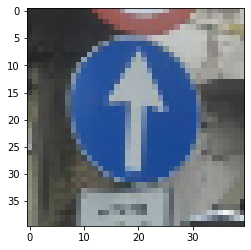

predizione 1


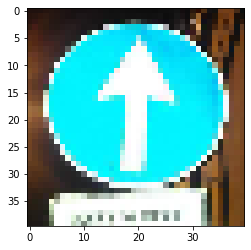

predizione 1


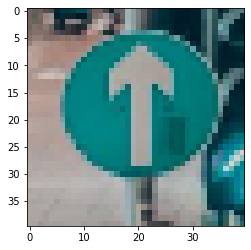

predizione 1


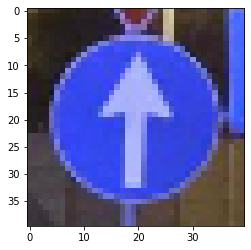

predizione 1


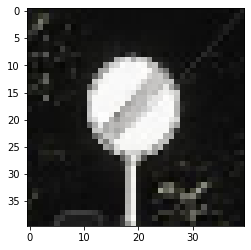

In [0]:
import matplotlib.pyplot as plt
for i in range(78,85):
  print("predizione "+str(prediction.argmax(axis=-1)[i]))
  plt.imshow(X[i])
  plt.show()